## Hangman

We build and test a hangman solver: an unknown word is given, and the solver only knows its length. One round consists of the solver guessing a letter, and the corresponding locations of that letter (if any) being revealed. We consider the game lost if the solver makes more than five errors (i.e. wrong guesses).

Import wordfreq and nltk for word frequency and the corpus of words itself, respectively:

In [ ]:
!pip install wordfreq
from wordfreq import word_frequency

import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

# load all english words

!pip install nltk
import nltk
nltk.download('words')
from nltk.corpus import words

word_list = [word.lower() for word in words.words()]

# assign frequencies

word_freqs = {w.lower(): word_frequency(w.lower(), 'en') for w in word_list}

letter_counts = Counter()
for w in word_list:
    for c in w:
        letter_counts[c] += word_freqs[w]

total = sum(letter_counts.values())
letter_freqs = {c: count/total for c,count in letter_counts.items()}

sorted_letter_freqs = sorted(list("abcdefghijklmnopqrstuvwxyz"), key = lambda x: (letter_freqs[x] if x in letter_freqs else 0), reverse = True)

In [ ]:
#print(sorted_letter_freqs)

['e', 't', 'o', 'a', 'h', 'i', 'n', 'r', 's', 'l', 'd', 'f', 'u', 'c', 'm', 'y', 'w', 'g', 'b', 'p', 'v', 'k', 'j', 'x', 'q', 'z']


The following function gives us all words, with their frequencies, that follow the current pattern:

In [7]:
def list_isolator(length, pattern, word_freqs, forbidden_letters = None):
    if forbidden_letters is None:
        forbidden_letters = set()
    filtered = []
    for word, freq in word_freqs.items():
        if len(word) != length:
            continue
        
        detected_forbidden = False
        
        for letter in forbidden_letters:
            if letter in word:
                detected_forbidden = True
        
        if detected_forbidden:
            continue

        match = True
        for i,c in enumerate(pattern):
            if c != '_' and word[i] != c:
                match = False
                break
        if match:
            filtered.append((word,freq))
    
    filtered.sort(key = lambda x: x[1], reverse = True)
    return filtered

This guessing function guesses the next word in the following way: for each remaining possible letter (i.e. all letters except those already guessed, be it correctly or incorrectly), we calculate a weighted score by summing up frequency^power, where power is some preset value, and frequency is the frequency of the given word in English, for every instance of that letter across all words. For example, for power = 1, the contribution of the word "example" to the weight of "e" will be freq("example") + freq("example"), since e appears twice. 

We also allow for an optional randomness parameter, which then selects the next letter from the list of letters sorted by weight using a distribution which is a function of this parameter. Setting randomness to be -1 makes the guess function simply select the letter with the highest weight.

In [8]:
def guess(length, pattern, word_freqs, wrongly_guessed_letters, correctly_guessed_letters, randomness = 0.1, power = 1):

    filtered = list_isolator(length,pattern,word_freqs,wrongly_guessed_letters)

    #print("pattern:", pattern)
    #print("filtered:", filtered)
    
    letter_counts = Counter()

    for word, freq in filtered:
        for letter in word:
            if letter not in correctly_guessed_letters:
                letter_counts[letter] += freq**power
    
    if not letter_counts:
        return None

    if randomness == -1:
        max_value = max(letter_counts.values())
        for c in letter_counts:
            if letter_counts[c] == max_value:
                return c

    letters, weights = zip(*letter_counts.items())
    #print(guessed_letters, letters)
    weights = [max(w**(1-randomness), 1e-12) for w in weights]
    total = sum(weights)
    probs = [w/total for w in weights]
    
    return random.choices(letters,probs)[0]
    

    


This guessing function prescribes weights to letters based on the entropy of guessing that letter (and then performs an optional random selection with distribution determined by parameter "randomness" as in the first guessing function), instead of its overall (weighted) frequency in the language.

The entropy $E$ assigned to a letter $l$ is calculated as follows: iterate over all possible remaining words, and record the pattern which would result from our current pattern if that were the correct word and we were to guess letter $l$. For example, suppose the current pattern is "e_____e" and we are considering the letter "x". Then the resulting pattern, if "example" were the actual word we are seeking, would be "ex____e". Doing this for all words, we obtain a set of possible patterns together with multiplicities (For example, "ex____e" would also appear when considering the word "examine"). Then the entropy $E(l)$ is computed by $$E(l) = \sum_p -p\log(p),$$ where $p = \frac{\textrm{multiplicity}}{\textrm{total count}}$ for each resulting pattern. Here multiplicity refers to how many times that given pattern was created, and total count refers to the sum of all multiplicities.

We wish to *maximize* the entropy (perhaps counterintuitively), since this corresponds to partitions of the remaining word set in which the individual bins are as small as possible.

In [9]:
def guess_entropy(length, pattern, word_freqs, wrongly_guessed_letters, correctly_guessed_letters, randomness = 0.1, power = 1):

    filtered = list_isolator(length,pattern,word_freqs,wrongly_guessed_letters)

    if not filtered:
        return None

    candidate_words = [word for word, freq in filtered]

    # calculate entropy for every letter not already guessed

    entropy_dct = {}
    letters = set("abcdefghijklmnopqrstuvwxyz") - wrongly_guessed_letters - correctly_guessed_letters

    for letter in letters:

        pattern_counts = defaultdict(int)

        for word in candidate_words:
            new_pattern = list(pattern)
            for i,c in enumerate(word):
                if c == letter:
                    new_pattern[i] = letter
            new_pattern = ''.join(new_pattern)
            pattern_counts[new_pattern] += 1
        
        # calculate prob. of each resulting pattern
        total = sum(pattern_counts.values())
        probs = [count/total for count in pattern_counts.values()]

        entropy = sum(p * (-np.log2(p)) for p in probs)
        entropy_dct[letter] = entropy**power

    if not entropy_dct:
        return None

    # convert to probabilities, apply randomness/selection criterion

    if randomness == -1:
        max_value = max(entropy_dct.values())
        for c in entropy_dct:
            if entropy_dct[c] == max_value:
                return c
    
    l, scores = zip(*entropy_dct.items())
    scores = [max(s**(1-randomness),1e-12) for s in scores]
    total_score = sum(scores)
    probs = [s/total_score for s in scores]

    return random.choices(l, probs)[0]

Below is the naive guess function, where our next guess is simply the most frequent letter that we have not guessed yet:

In [11]:
def naive_guess(sorted_letter_freqs,guessed_letters):
    for c in sorted_letter_freqs:
        if c in guessed_letters:
            continue
        else:
            return c

The following functions runs one iteration of the game. The player (computer) has max_tries tries to guess the word, and uses the entropy-based guessing function for the first entropy_rounds many rounds, followed by the ordinary guess function. These have randomness parameters randomness1 and randomness2, respectively.

In [12]:
def trial(answer,word_freqs,power, randomness1, randomness2, display = False, entropy_rounds = 0):
    #answer = input(str)
    length = len(answer)
    remaining = length
    pattern = ['_']*length
    max_tries = 30
    wrongly_guessed_letters = set()
    correctly_guessed_letters = set()
    win = False

    for round in range(max_tries):
        if display:
            print(f"----- \n\n ROUND {round+1}")
        if round < entropy_rounds:
            guessed_letter = guess_entropy(length,pattern,word_freqs,wrongly_guessed_letters,correctly_guessed_letters,randomness = randomness1, power = power)
        else:
            guessed_letter = guess(length,pattern,word_freqs,wrongly_guessed_letters,correctly_guessed_letters,randomness = randomness2, power = power)
            #guessed_letter = naive_guess(sorted_letter_freqs,wrongly_guessed_letters | correctly_guessed_letters)
        #guessed_letter = guess(length,pattern,word_freqs,wrongly_guessed_letters,correctly_guessed_letters,randomness = 0, power = 2)
        if display:
            print("guessing", guessed_letter)
        featured = False
        for i in range(len(pattern)):
            if pattern[i] == '_' and answer[i] == guessed_letter:
                featured = True
                pattern[i] = guessed_letter
                remaining -= 1
        if not featured:
            wrongly_guessed_letters.add(guessed_letter)
        else:
            correctly_guessed_letters.add(guessed_letter)
            
        if display:
            print("".join(pattern))
        #print(guessed_letters)
        if remaining == 0:
            win = True
            break

    return (round+1,len(wrongly_guessed_letters)) if win else -1

Now we run the game many times, and plot performance. We display results for 1.6 as the power parameter as that seems to perform well empirically. We display results for strategies where only the first $i$ rounds use the entropy-based guessing function, with the remainder using the ordinary non-naive guessing function.

In [32]:
def process(entropy_rounds_list, powers_list, randomness1 = -1, randomness2 = 0.5, word_amount = 1000):
    sample_words = random.sample(word_list, word_amount)
    #print(sample_words)

    #powers_list = [1.6]
    results = {} # for plotting results

    for entropy_rounds in entropy_rounds_list:
        for power in powers_list:
            print(f"---------\n Amount of entropy-based guessing rounds: {entropy_rounds} \n Power parameter: {power} \n ---------")
            ans = []
            ans_full = []
            for answer in sample_words:
                total_guesses, wrong_guesses = trial(answer,word_freqs,power, randomness1 = -1, randomness2 = 0.5, display = False, entropy_rounds = entropy_rounds)
                ans_full.append((answer,total_guesses,wrong_guesses))
                ans.append(wrong_guesses)
                #if len(ans) % 100 == 0:
                #    print("working")
            for i in range(6):
                print(f"percentage correctly guessed with <= {i} errors: {sum(1 for a in ans if a <= i)/len(ans)}")
            print(f"sample (word, total guesses, wrong guesses): {ans_full[:10]}")
        
            # success rates
            performance = [sum(1 for a in ans if a <= i)/len(ans) for i in range(6)]
            results[entropy_rounds] = performance
    
    plt.figure(figsize = (4,3))
    for entropy_rounds, performance in results.items():
        plt.plot(range(6), performance, label = f"{entropy_rounds} entropy guess rounds")
    
        plt.xlabel("Error threshold (i)")
        plt.ylabel("Proportion guessed with <= i errors")
        plt.title(f"Performance with different entropy rounds (sample size = {word_amount})")
        plt.legend()
        plt.grid(True)
        plt.show()

---------
 Amount of entropy-based guessing rounds: 0 
 Power parameter: 1.6 
 ---------
percentage correctly guessed with <= 0 errors: 0.078
percentage correctly guessed with <= 1 errors: 0.184
percentage correctly guessed with <= 2 errors: 0.296
percentage correctly guessed with <= 3 errors: 0.456
percentage correctly guessed with <= 4 errors: 0.566
percentage correctly guessed with <= 5 errors: 0.686
sample (word, total guesses, wrong guesses): [('syndical', 10, 2), ('exsufflate', 14, 6), ('beelbow', 16, 11), ('scyllaea', 9, 3), ('kisswise', 15, 10), ('parrel', 16, 11), ('noncapillary', 12, 3), ('breastplate', 13, 5), ('unsister', 17, 10), ('externomedian', 10, 0)]
---------
 Amount of entropy-based guessing rounds: 1 
 Power parameter: 1.6 
 ---------
percentage correctly guessed with <= 0 errors: 0.092
percentage correctly guessed with <= 1 errors: 0.238
percentage correctly guessed with <= 2 errors: 0.376
percentage correctly guessed with <= 3 errors: 0.504
percentage correctly g

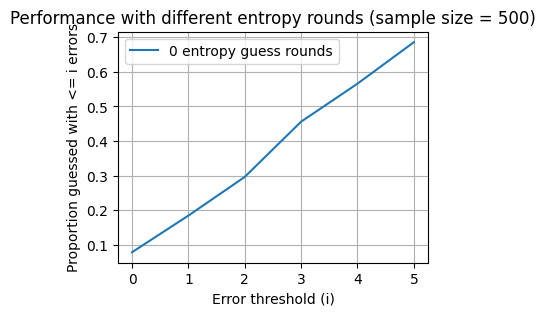

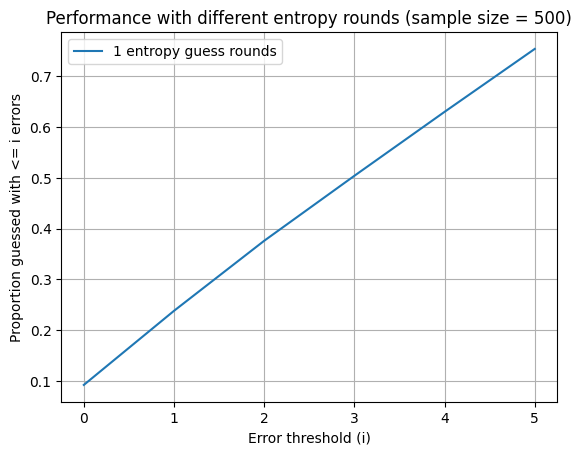

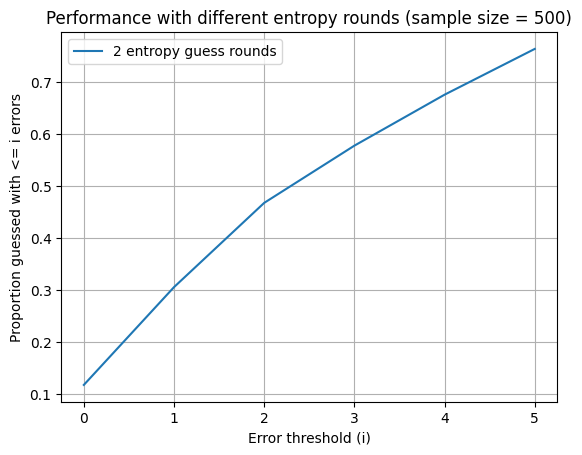

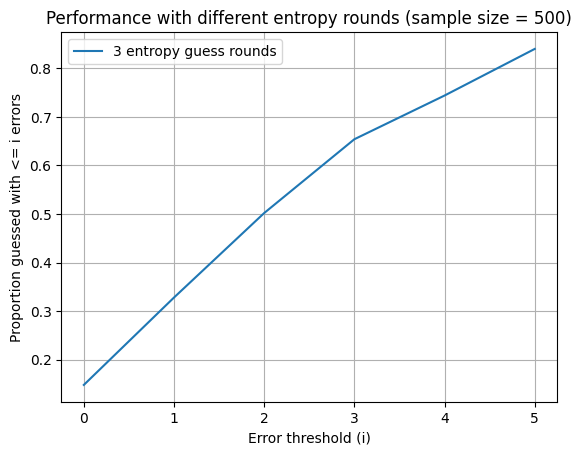

In [33]:
process([0,1,2,3],powers_list = [1.6], randomness1 = -1, randomness2 = 0.5, word_amount = 500)

Apparently having more entropy-based guessing rounds is better. We make some more plots:

---------
 Amount of entropy-based guessing rounds: 6 
 Power parameter: 1.6 
 ---------
percentage correctly guessed with <= 0 errors: 0.0475
percentage correctly guessed with <= 1 errors: 0.2405
percentage correctly guessed with <= 2 errors: 0.5425
percentage correctly guessed with <= 3 errors: 0.761
percentage correctly guessed with <= 4 errors: 0.853
percentage correctly guessed with <= 5 errors: 0.9005
sample (word, total guesses, wrong guesses): [('nerval', 8, 2), ('conveyancing', 11, 2), ('stridor', 8, 2), ('have', 9, 5), ('pinnation', 7, 1), ('glycocholate', 13, 4), ('myxomatous', 11, 3), ('phrenicotomy', 12, 1), ('actinula', 9, 2), ('hejazian', 11, 4)]


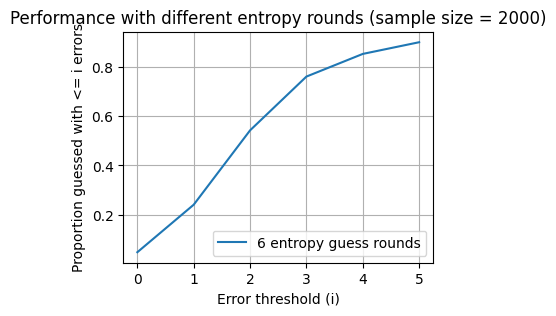

In [34]:
process([6],powers_list = [1.6], randomness1 = -1, randomness2 = 0.5, word_amount = 2000)

---------
 Amount of entropy-based guessing rounds: 6 
 Power parameter: 1.6 
 ---------
percentage correctly guessed with <= 0 errors: 0.0508
percentage correctly guessed with <= 1 errors: 0.2486
percentage correctly guessed with <= 2 errors: 0.5366
percentage correctly guessed with <= 3 errors: 0.7524
percentage correctly guessed with <= 4 errors: 0.8482
percentage correctly guessed with <= 5 errors: 0.8974
sample (word, total guesses, wrong guesses): [('pollenigerous', 12, 2), ('regiment', 9, 2), ('sabot', 12, 7), ('rhyparographist', 12, 2), ('harvestbug', 13, 3), ('sclerodermatitis', 12, 1), ('moringad', 9, 1), ('netting', 7, 2), ('hymenaeus', 9, 1), ('voyageable', 12, 4)]


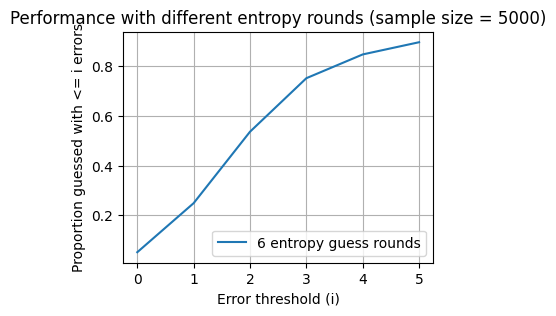

In [35]:
process([6],powers_list = [1.6], randomness1 = -1, randomness2 = 0.5, word_amount = 5000)

So the performance overall is a nearly $90\%$ success rate with guessing the word with at most five errors.

For comparison, let us consider naive guessing only:

In [36]:
def naive_trial(answer,word_freqs,display = False):
    #answer = input(str)
    length = len(answer)
    remaining = length
    pattern = ['_']*length
    max_tries = 30
    wrongly_guessed_letters = set()
    correctly_guessed_letters = set()
    win = False

    for round in range(max_tries):
        if display:
            print(f"----- \n\n ROUND {round+1}")
        guessed_letter = naive_guess(sorted_letter_freqs,wrongly_guessed_letters | correctly_guessed_letters)
        if display:
            print("guessing", guessed_letter)
        featured = False
        for i in range(len(pattern)):
            if pattern[i] == '_' and answer[i] == guessed_letter:
                featured = True
                pattern[i] = guessed_letter
                remaining -= 1
        if not featured:
            wrongly_guessed_letters.add(guessed_letter)
        else:
            correctly_guessed_letters.add(guessed_letter)
            
        if display:
            print("".join(pattern))
        #print(guessed_letters)
        if remaining == 0:
            win = True
            break

    return (round+1,len(wrongly_guessed_letters)) if win else (-1,-1)

In [37]:
def naive_process(word_amount = 1000):
    sample_words = random.sample(word_list, word_amount)
    #print(sample_words)
    
    ans = []
    ans_full = []
    for answer in sample_words:
        total_guesses, wrong_guesses = naive_trial(answer,word_freqs, display = False)
        ans_full.append((answer,total_guesses,wrong_guesses))
        ans.append(wrong_guesses)

    for i in range(6):
        print(f"percentage correctly guessed with <= {i} errors: {sum(1 for a in ans if a <= i)/len(ans)}")
    print(ans_full)

    # success rates
    performance = [sum(1 for a in ans if a <= i)/len(ans) for i in range(6)]

    plt.figure(figsize = (4,3))
    plt.plot(range(6), performance, label = f"all naive guessing rounds")

    plt.xlabel("Error threshold (i)")
    plt.ylabel("Proportion guessed with <= i errors")
    plt.title(f"Performance with all naive guessing rounds (sample size = {word_amount})")
    plt.legend()
    plt.grid(True)
    plt.show()

percentage correctly guessed with <= 0 errors: 0.00032
percentage correctly guessed with <= 1 errors: 0.00198
percentage correctly guessed with <= 2 errors: 0.00716
percentage correctly guessed with <= 3 errors: 0.0176
percentage correctly guessed with <= 4 errors: 0.03834
percentage correctly guessed with <= 5 errors: 0.07524
[('jincamas', 23, 16), ('illuministic', 15, 7), ('invocatory', 21, 12), ('potting', 20, 14), ('overman', 21, 14), ('dogcatcher', 18, 9), ('pasteur', 20, 13), ('nondieting', 18, 11), ('bronchotracheal', 19, 9), ('foolocracy', 16, 9), ('knuckler', 22, 15), ('ker', 22, 19), ('curvaceous', 21, 13), ('mentocondylial', 16, 5), ('claught', 18, 11), ('multiparient', 20, 10), ('textarian', 24, 17), ('unco', 14, 10), ('autotypography', 20, 11), ('disceptation', 20, 10), ('repelling', 20, 13), ('diathermometer', 15, 6), ('inower', 17, 11), ('unnurtured', 13, 7), ('bassine', 19, 13), ('spotlight', 20, 12), ('photochromography', 20, 10), ('chemesthesis', 15, 8), ('immaculatel

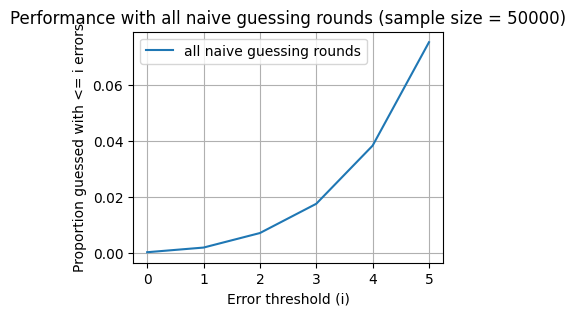

In [38]:
naive_process(word_amount = 50000)